In [1]:
import pandas as pd
import json
import os
import numpy as np
import time
import ipywidgets as widgets
from bqplot import *
import qgrid

pd.options.display.max_columns = 999


import matplotlib.pyplot as plt
from matplotlib.patches import Arc

from mplsoccer import Pitch, VerticalPitch, add_image, FontManager
import seaborn as sns
from matplotlib import rcParams
import math
from PIL import Image

from highlight_text import ax_text
from matplotlib import animation
hfont = {'fontname':'Georgia'}

from scipy import optimize as op
from scipy.spatial import ConvexHull

from collections import Counter

from itertools import chain
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import itertools
from scipy.ndimage import gaussian_filter
from scipy import stats
from scipy.spatial.distance import cdist


C:\Users\mishr\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
C:\Users\mishr\AppData\Local\Temp/ipykernel_26072/2057282659.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was too old on your system - pyarrow 10.0.1 is the current minimum supported version as of this release.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:
path_events = 'data/'
df_event_names = pd.read_csv(f'{path_events}event_names.csv')

dict_event_names = df_event_names.set_index('event_type_id').to_dict()['event_description']


qualifier_names = pd.read_csv(f'{path_events}qualifier_names.csv')
dict_qualifier_names = qualifier_names.set_index('qualifierId').to_dict()['qualifier']


In [2]:
def load_event_data(file_name, base_path,columns_to_select):
    # read in event file
    with open(f'{base_path}/{file_name}') as f:
        data=json.loads(f.read())

    f.close()
    
    # transform data into pandas dataframe
    df_events = pd.json_normalize(data['liveData']['event'])
    
    # preprocess event data and keep relevant information only
    # remove not required columns
    
    missing_columns = set(columns_to_select) - set(df_events.columns)
    
    for missing_column in missing_columns:
        df_events[missing_column] = np.nan
        
    df_events = df_events[columns_to_select]
 
    # add timeelapsed to each event
    df_events['timestamp'] = pd.to_datetime(df_events.timeStamp,format='ISO8601').apply(lambda x: x.timestamp())

    df_events = df_events.query('periodId in [1,2]')

    def add_timeelapsed_to_events(df):
        start_time = df.query('typeId==32')['timestamp'].iloc[0]
        df['timestamp_new'] = np.int64((df['timestamp'] - start_time)*1000)

        df['timeelapsed'] = df['timestamp_new'].apply(lambda x: (40 * round(x/40))/1000)

        return df

    df_events = df_events.groupby('periodId').apply(add_timeelapsed_to_events)

    df_events = df_events.drop(columns=['timeStamp','timestamp','timestamp_new'])
    
    # rename some columns
    df_events = df_events.rename(columns=
        {
            'periodId':'current_phase',
            'typeId':'event_type_id',
            'timeMin':'period_minute',
            'timeSec':'period_second'
        }
    )
    
    # add event descriptions
    df_events['event_description'] = df_events['event_type_id'].map(dict_event_names)
    df_events = df_events.reset_index(drop=True)
    
    return df_events


In [4]:
# load as lists

with open('data/all_games_active.json', 'r') as json_file:
    all_games = json.load(json_file)

In [5]:
# load as lists

with open('data/corner_timeelapsed_store.json', 'r') as json_file:
    corner_timeelpased_store = json.load(json_file)

In [ ]:
acc_list = []
speed_list = []
corner_type_list = []
corner_sequence_list = []
above_2 = []


for file_name in all_games.keys():
    counter = 0
    for corner_num in all_games[file_name].keys():

        _, _, _, _, _, corner_type, sequence = corner_timeelpased_store[file_name][counter]
        corner_type_list.append(corner_type)
        corner_sequence_list.append(sequence.split("> ")[-1])
        counter +=1
        

In [ ]:
shots = ['Attempt Saved', 'Miss', "Goal"]

shots_attempt = [1 if ele in shots else 0 for ele in corner_sequence_list]

In [22]:

base_path_event = 'all_OV_passes/'
counter = 0
x_corner = []
y_corner = []
x_loc = []
y_loc = []
pressure = []
event_description = []
diff = []

for file_name in all_games.keys():
    
    store_corner_count = 0
    for corner_num in all_games[file_name].keys():
        
        if shots_attempt[counter]:

            iloc_frame, start_time, _, end_time, phase, corner_type, sequence = corner_timeelpased_store[file_name][store_corner_count]

            df_events = load_event_data(
                base_path=base_path_event,
                file_name=file_name,columns_to_select = ['typeId','contestantId','periodId','timeMin', 'timeSec','timeStamp','playerId','outcome','x', 'y',  'pressure.pressureReceived.value', 'pressure.player','qualifier']

            )

            x_coor,y_coor = df_events[(df_events['timeelapsed'] == start_time) & (df_events['current_phase'] == phase)][['x','y']].values[0]

    
            x_shot,y_shot,pressure_value,event_desc = df_events[(df_events['timeelapsed'] == end_time) & (df_events['current_phase'] == phase)][['x','y','pressure.pressureReceived.value', 'event_description']].values[0]
            
            x_corner.append(float(x_coor))
            y_corner.append(float(y_coor))
            x_loc.append(float(x_shot))
            y_loc.append(float(y_shot))
            pressure.append(pressure_value)
            event_description.append(event_desc)
            diff.append(end_time - start_time)
            
        counter +=1
        store_corner_count +=1
        

C:\Users\mishr\AppData\Local\Temp/ipykernel_26072/4179962703.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_events = df_events.groupby('periodId').apply(add_timeelapsed_to_events)
C:\Users\mishr\AppData\Local\Temp/ipykernel_26072/4179962703.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_events = df_events.groupby('periodId').apply(add_timeelapsed_to_events)
C:\Users\mishr\AppData\Local\Tem

C:\Users\mishr\AppData\Local\Temp/ipykernel_26072/4179962703.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_events = df_events.groupby('periodId').apply(add_timeelapsed_to_events)
C:\Users\mishr\AppData\Local\Temp/ipykernel_26072/4179962703.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_events = df_events.groupby('periodId').apply(add_timeelapsed_to_events)
C:\Users\mishr\AppData\Local\Tem

C:\Users\mishr\AppData\Local\Temp/ipykernel_26072/4179962703.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_events = df_events.groupby('periodId').apply(add_timeelapsed_to_events)
C:\Users\mishr\AppData\Local\Temp/ipykernel_26072/4179962703.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_events = df_events.groupby('periodId').apply(add_timeelapsed_to_events)
C:\Users\mishr\AppData\Local\Tem

C:\Users\mishr\AppData\Local\Temp/ipykernel_26072/4179962703.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_events = df_events.groupby('periodId').apply(add_timeelapsed_to_events)
C:\Users\mishr\AppData\Local\Temp/ipykernel_26072/4179962703.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_events = df_events.groupby('periodId').apply(add_timeelapsed_to_events)
C:\Users\mishr\AppData\Local\Tem

C:\Users\mishr\AppData\Local\Temp/ipykernel_26072/4179962703.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_events = df_events.groupby('periodId').apply(add_timeelapsed_to_events)
C:\Users\mishr\AppData\Local\Temp/ipykernel_26072/4179962703.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_events = df_events.groupby('periodId').apply(add_timeelapsed_to_events)
C:\Users\mishr\AppData\Local\Tem

C:\Users\mishr\AppData\Local\Temp/ipykernel_26072/4179962703.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_events = df_events.groupby('periodId').apply(add_timeelapsed_to_events)
C:\Users\mishr\AppData\Local\Temp/ipykernel_26072/4179962703.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_events = df_events.groupby('periodId').apply(add_timeelapsed_to_events)
C:\Users\mishr\AppData\Local\Tem

C:\Users\mishr\AppData\Local\Temp/ipykernel_26072/4179962703.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_events = df_events.groupby('periodId').apply(add_timeelapsed_to_events)
C:\Users\mishr\AppData\Local\Temp/ipykernel_26072/4179962703.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_events = df_events.groupby('periodId').apply(add_timeelapsed_to_events)
C:\Users\mishr\AppData\Local\Tem

C:\Users\mishr\AppData\Local\Temp/ipykernel_26072/4179962703.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_events = df_events.groupby('periodId').apply(add_timeelapsed_to_events)
C:\Users\mishr\AppData\Local\Temp/ipykernel_26072/4179962703.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_events = df_events.groupby('periodId').apply(add_timeelapsed_to_events)
C:\Users\mishr\AppData\Local\Tem

C:\Users\mishr\AppData\Local\Temp/ipykernel_26072/4179962703.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_events = df_events.groupby('periodId').apply(add_timeelapsed_to_events)
C:\Users\mishr\AppData\Local\Temp/ipykernel_26072/4179962703.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_events = df_events.groupby('periodId').apply(add_timeelapsed_to_events)
C:\Users\mishr\AppData\Local\Tem

C:\Users\mishr\AppData\Local\Temp/ipykernel_26072/4179962703.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_events = df_events.groupby('periodId').apply(add_timeelapsed_to_events)
C:\Users\mishr\AppData\Local\Temp/ipykernel_26072/4179962703.py:35: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_events = df_events.groupby('periodId').apply(add_timeelapsed_to_events)
C:\Users\mishr\AppData\Local\Tem

In [23]:
def scale_coordinates(df):
    df.loc[:, 'x_corner'] = df['x_corner'].map(lambda x: (x / 100) * 105)
    df.loc[:, 'y_corner'] = df['y_corner'].map(lambda y: (y / 100) * 68)
    
    df.loc[:, 'x_loc'] = df['x_loc'].map(lambda x: (x / 100) * 105)
    df.loc[:, 'y_loc'] = df['y_loc'].map(lambda y: (y / 100) * 68)

def closest_corner(row):
        
    target_coordinates = [(105, 68), (105,0)]
    
    x_coor,y_coor = row[0], row[1]

    # Find the closest target coordinates
    closest_coordinates = min(target_coordinates, key=lambda coord: ((x_coor - coord[0])**2 + (y_coor - coord[1])**2))

    return closest_coordinates


def transform_coordinates(df):
    # Apply transformation to make the corners being taken from top left corner
    for index, row in df.iterrows():
        
        closest_coordinates = closest_corner(row)
        
        if closest_coordinates == (105, 68):
            # Do nothing
            pass
        elif closest_coordinates == (105, 0):
            # Flip y coordinates
            df.at[index, 'y_loc'] = 68 - row['y_loc']


In [25]:
shot_location_df = pd.DataFrame(list(zip(x_corner, y_corner, x_loc, y_loc, pressure, event_description, diff)),
               columns =['x_corner', 'y_corner', 'x_loc', 'y_loc', 'pressure', 'event_description', 'diff'])

In [26]:
scale_coordinates(shot_location_df)
transform_coordinates(shot_location_df)

shot_location_df.head()

C:\Users\mishr\AppData\Local\Temp/ipykernel_26072/682832447.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_coor,y_coor = row[0], row[1]


,x_corner,y_corner,x_loc,y_loc,pressure,event_description,diff
0,104.475,0.34,91.77,35.972,medium,Attempt Saved,1.68
1,104.475,67.66,83.37,32.844,low,Attempt Saved,4.12
2,104.475,67.66,93.24,38.216,high,Miss,1.36
3,104.475,0.34,95.97,32.232,high,Miss,1.80
4,104.475,67.66,95.13,39.508,high,Miss,1.56


In [27]:
less_than_2 = shot_location_df[shot_location_df['diff'] <= 2]

In [28]:
less_than_3 = shot_location_df[shot_location_df['diff'] <= 3]

In [29]:
less_than_5 = shot_location_df[shot_location_df['diff'] <= 5]

# Shots within 2 seconds

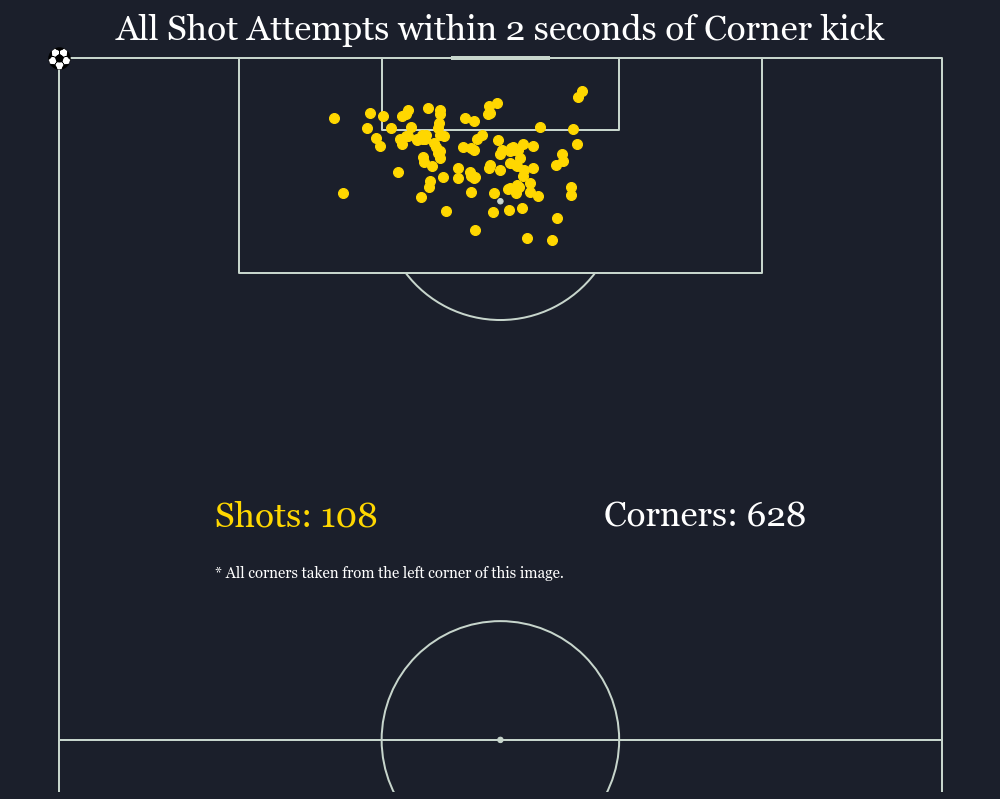

In [30]:

pitch = VerticalPitch(pitch_color='#1b1f2b',pitch_type='custom',
            pitch_length=105, pitch_width=68,figsize=(14, 12), line_zorder=2, line_color='#c7d5cc', half = True)

fig, ax = pitch.draw(figsize=(14, 12))
fig.set_facecolor('#1b1f2b')


pitch.scatter(less_than_2['x_loc'],less_than_2['y_loc'] , marker = 'o',ax=ax,zorder=3,s=100, color = "gold")

#         ax.text(pressure[idx], 60, 40)
pitch.scatter(105, 68,c='white',marker="football",ax=ax,zorder=3,s=500)

plt.title("All Shot Attempts within 2 seconds of Corner kick",color='white',size =35, **hfont, y = 0.95)

plt.text(56,69,"Shots: " + str(len(less_than_2)),color='gold',size =35, **hfont)
plt.text(26,69,"Corners: " + str(628),color='white',size =35, **hfont)

plt.text(56,65,"* All corners taken from the left corner of this image.",color='white',size =15, **hfont)


# plt.savefig('figures/within_2seconds',dpi=480,bbox_inches='tight',facecolor='#1b1f2b')
plt.show()



# Shots within 3 seconds

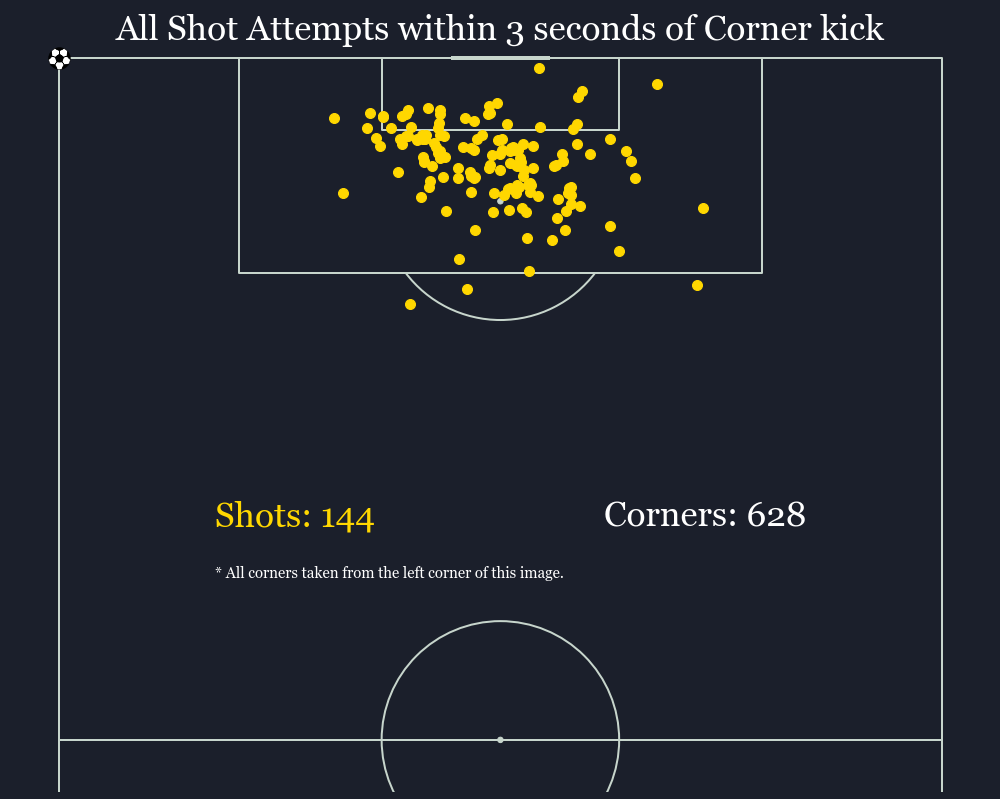

In [31]:

pitch = VerticalPitch(pitch_color='#1b1f2b',pitch_type='custom',
            pitch_length=105, pitch_width=68,figsize=(14, 12), line_zorder=2, line_color='#c7d5cc', half = True)

fig, ax = pitch.draw(figsize=(14, 12))
fig.set_facecolor('#1b1f2b')


pitch.scatter(less_than_3['x_loc'],less_than_3['y_loc'] , marker = 'o',ax=ax,zorder=3,s=100, color = "gold")

#         ax.text(pressure[idx], 60, 40)
pitch.scatter(105, 68,c='white',marker="football",ax=ax,zorder=3,s=500)

plt.title("All Shot Attempts within 3 seconds of Corner kick",color='white',size =35, **hfont, y = 0.95)

plt.text(56,69,"Shots: " + str(len(less_than_3)),color='gold',size =35, **hfont)
plt.text(26,69,"Corners: " + str(628),color='white',size =35, **hfont)

plt.text(56,65,"* All corners taken from the left corner of this image.",color='white',size =15, **hfont)


# plt.savefig('figures/within_3seconds',dpi=480,bbox_inches='tight',facecolor='#1b1f2b')
plt.show()



# Shots within 5 seconds

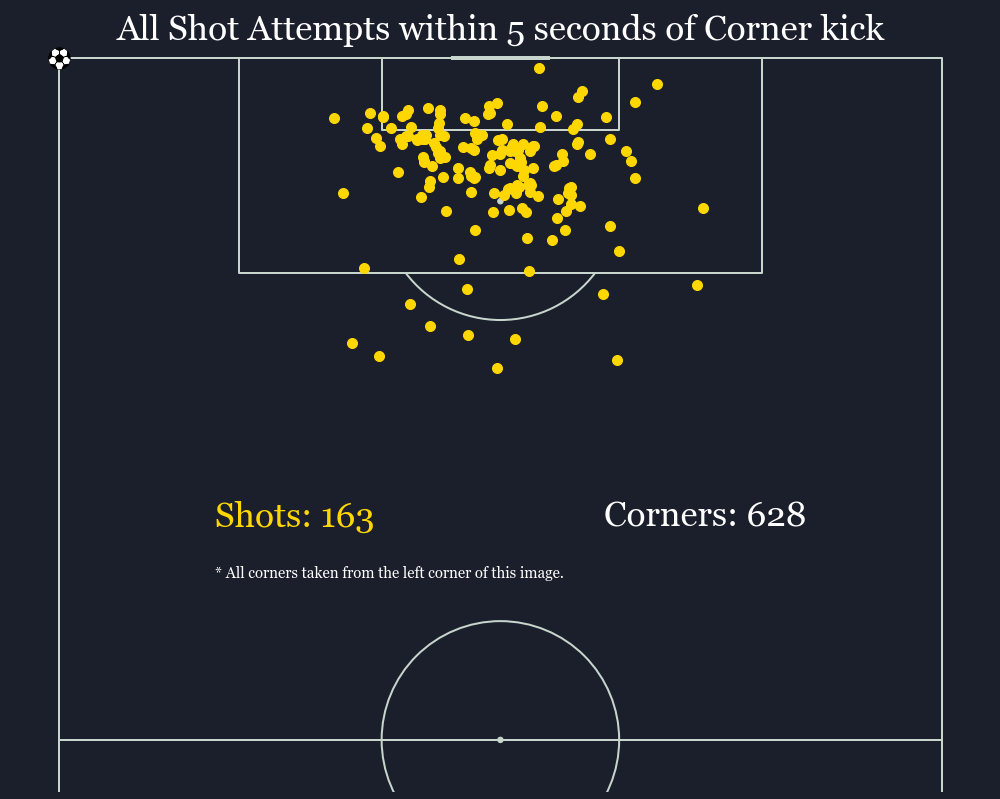

In [32]:

pitch = VerticalPitch(pitch_color='#1b1f2b',pitch_type='custom',
            pitch_length=105, pitch_width=68,figsize=(14, 12), line_zorder=2, line_color='#c7d5cc', half = True)

fig, ax = pitch.draw(figsize=(14, 12))
fig.set_facecolor('#1b1f2b')


pitch.scatter(less_than_5['x_loc'],less_than_5['y_loc'] , marker = 'o',ax=ax,zorder=3,s=100, color = "gold")

#         ax.text(pressure[idx], 60, 40)
pitch.scatter(105, 68,c='white',marker="football",ax=ax,zorder=3,s=500)

plt.title("All Shot Attempts within 5 seconds of Corner kick",color='white',size =35, **hfont, y = 0.95)

plt.text(56,69,"Shots: " + str(len(less_than_5)),color='gold',size =35, **hfont)
plt.text(26,69,"Corners: " + str(628),color='white',size =35, **hfont)

plt.text(56,65,"* All corners taken from the left corner of this image.",color='white',size =15, **hfont)


# plt.savefig('figures/within_5seconds',dpi=480,bbox_inches='tight',facecolor='#1b1f2b')
plt.show()



# All Shots

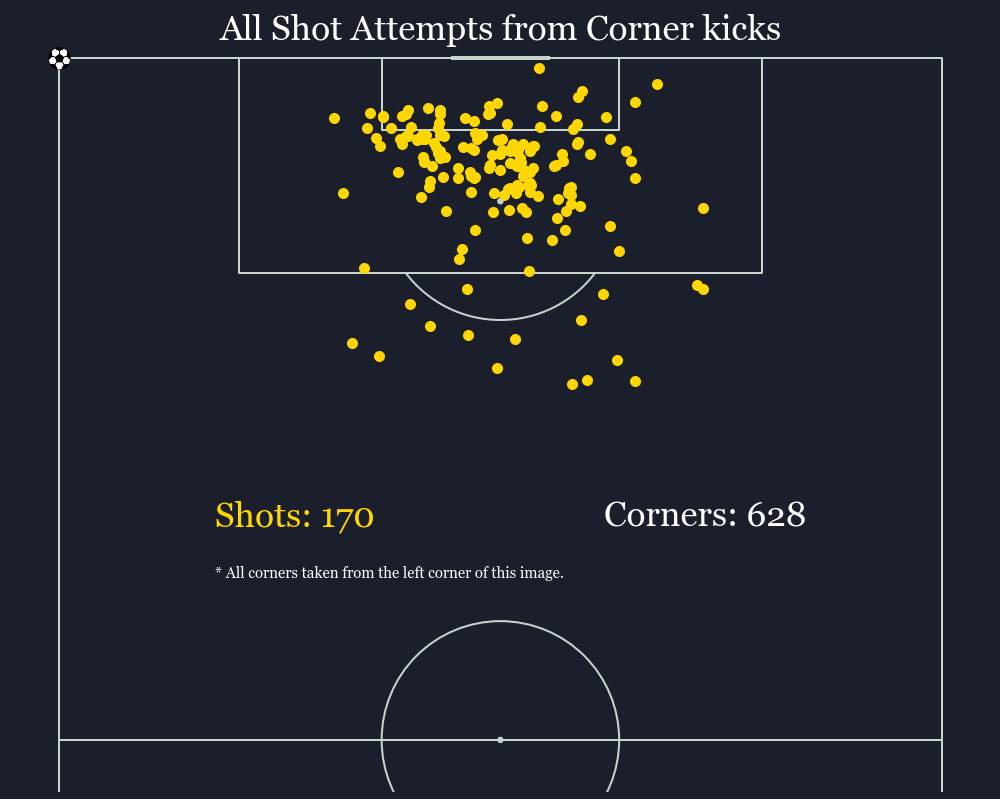

In [33]:

pitch = VerticalPitch(pitch_color='#1b1f2b',pitch_type='custom',
            pitch_length=105, pitch_width=68,figsize=(14, 12), line_zorder=2, line_color='#c7d5cc', half = True)

fig, ax = pitch.draw(figsize=(14, 12))
fig.set_facecolor('#1b1f2b')


pitch.scatter(shot_location_df['x_loc'],shot_location_df['y_loc'] , marker = 'o',ax=ax,zorder=3,s=100, color = "gold")

#         ax.text(pressure[idx], 60, 40)
pitch.scatter(105, 68,c='white',marker="football",ax=ax,zorder=3,s=500)


# cmap = sns.cubehelix_palette(start=2, rot=0, dark=0, light=.95, reverse=True, as_cmap=True)
# pitch.kdeplot(shot_location_df['x_loc'],shot_location_df['y_loc'], shade=True,n_levels=200,cmap = cmap,ax=ax, linewidths = 2)


plt.title("All Shot Attempts from Corner kicks",color='white',size =35, **hfont, y = 0.95)

plt.text(56,69,"Shots: " + str(len(shot_location_df)),color='gold',size =35, **hfont)
plt.text(26,69,"Corners: " + str(628),color='white',size =35, **hfont)

plt.text(56,65,"* All corners taken from the left corner of this image.",color='white',size =15, **hfont)



# plt.savefig('figures/all_shots',dpi=480,bbox_inches='tight',facecolor='#1b1f2b')
plt.show()



# Proximity

In [34]:
def euclidean_distance(point1, point2):

    """
    euclidean_distance(point1, point2)
    
    Finds the euclidean distance between 2 given points with x,y coordinates

    Parameters
    -----------
    
    point1/point2 (np array): x, y coordinates
     
    Returns
    -----------
    
    distance (float): euclidean distance between the 2 given points

    """  

    return np.linalg.norm(point1 - point2)

def euclidean_similarity(array1, array2):

    """
    euclidean_distance(point1, point2)
    
    Finds the closest points between the points in two different sets, using the linear sum assignment problem.
    for more info. https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.linear_sum_assignment.html

    Parameters
    -----------
    
    array1/array1 (np array):
     
    Returns
    -----------
    
    sum_dist (float): the total cost of the assignment 
    sol_rows (list): An array of row indices indices giving the optimal assignment. 
    sol_cols (list): An array of corresponding column indices giving the optimal assignment

    """  

    num_points1 = array1.shape[0]
    num_points2 = array2.shape[0]
    
    cost_matrix = np.zeros((num_points1, num_points2))
    
    for i in range(num_points1):
        for j in range(num_points2):
            cost_matrix[i, j] = euclidean_distance(array1[i], array2[j])
    

    # Perform linear sum assignment and get mean squared distance
    sol_rows, sol_cols = op.linear_sum_assignment(cost_matrix)
    sum_dist = cost_matrix[sol_rows, sol_cols].sum()
    # updated_cost_matrix = cost_matrix[sol_rows, sol_cols]


    return sum_dist, sol_rows, sol_cols


def active_players(x_coor, y_coor, attack_bool):
    
    if not attack_bool:
        distances = np.sqrt((x_coor - 105)**2 + (y_coor - 34)**2)

        # Find the index of the coordinates with the least distance
        min_distance_index = np.argmin(distances)
        
        x_coor = np.delete(x_coor, min_distance_index)
        y_coor = np.delete(y_coor, min_distance_index)

    # Remove coordinates that do not meet the conditions
    condition = (x_coor > 88) & (y_coor > 14) & (y_coor < 54)
    x_coor = x_coor[condition]
    y_coor = y_coor[condition]
    
    potential_zonal_markers = np.sum(x_coor > 99)
    
    
    
    return x_coor, y_coor, potential_zonal_markers


def distance_func(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance

In [35]:
counter = 0
closely_marked = []
distance_list = []

for file_name in all_games.keys():
    
    for corner_num in all_games[file_name].keys():

        frame_for_lsp = -1

        attack_x, attack_y = np.array([sublist for sublist in all_games[file_name][corner_num]['attacking_coors'] if sublist])[frame_for_lsp][:, :2].T.astype(float)
        def_x, def_y = np.array([sublist for sublist in all_games[file_name][corner_num]['defending_coors'] if sublist])[frame_for_lsp][:, :2].T.astype(float)
                
        attack_coord = np.column_stack((attack_x,attack_y))
        
        filtered_attack_coord = attack_coord[(attack_coord[:, 0] > 93) & (attack_coord[:, 1] > 20) & (attack_coord[:, 1] < 50)]
        
  
        defence_coord = np.column_stack((def_x,def_y))
        
        distances = cdist(filtered_attack_coord, defence_coord)

        # Find the indices of the closest coordinates
        closest_indices = np.argmin(distances, axis=1)

        # Get the closest coordinates from set2 for each coordinate in set1
        closest_coordinates = defence_coord[closest_indices]
        
        distances_to_closest = np.linalg.norm(filtered_attack_coord - closest_coordinates, axis=1)
        
        distance_list = distance_list + list(distances_to_closest)
        
        #if distance of more than half the active attacking players was found to be more than the median distance
        if np.sum(distances_to_closest > 1.45) >= (len(filtered_attack_coord) / 2):
            counter +=1
            
            closely_marked.append(0)
            
            
        else:
            closely_marked.append(1)
            

                                     
       

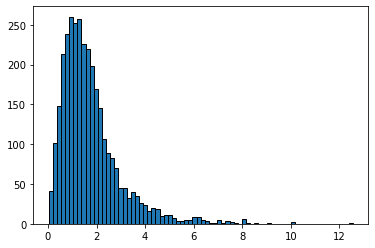

In [38]:
plt.hist(distance_list, bins='auto', edgecolor='black')  # 'auto' determines the number of bins automatically


plt.show()

In [39]:
print("mean", np.mean(distance_list))
print("median", np.median(distance_list))
print("Std", np.std(distance_list))

mean 1.7336491480686709
median 1.4557175754347842
Std 1.2452686267724256


In [40]:
len(closely_marked)

628

In [41]:
# features = pd.read_csv('data/features.csv')

In [42]:
# features['closely_marked'] = closely_marked

In [43]:
# features.to_csv('data/features.csv', index=False)